# Exercise: Speeding up the retrievals

David R. Thompson, Jet Propulsion Laboratory, California Institute of Technology<br>
Contact: david.r.thompson@jpl.nasa.gov
__________

This exercise demonstrates segmentation and empirical line extrapolation as one of many potential methods to enable OE analysis of full data cubes.  We first import libraries and define all model components.  We will use a simple 2-dimensional state vector.

In [1]:
import sys, os
import numpy as np
from os.path import join
import isofit

from figure_style import *
from isofit.core.forward import ForwardModel
from isofit.core.geometry import Geometry
from isofit.inversion.inverse import Inversion
from scipy.interpolate import interp1d 
from isofit.configs.configs import Config

instrument_settings = {"wavelength_file": "data/wavelengths.txt",
                       "integrations": 294,
                       "parametric_noise_file": "data/avirisng_noise.txt",
                       "unknowns": {
                             "cal_uncertainty_systematic_file": "../data/avirisng_systematic_error.txt",
                             "uncorrelated_radiometric_uncertainty": 0.01}}

rtm_settings = {"statevector": {
                  "H2OSTR": 
                    {"bounds": [1.5, 2.0], 
                     "scale": 0.01, 
                     "init": 1.75, 
                     "prior_mean": 1.75, 
                     "prior_sigma": 2.0},
                  "AOT550": 
                    {"bounds": [0.01, 0.1], 
                     "scale": 0.01, 
                     "init": 0.05, 
                     "prior_mean": 0.05, 
                     "prior_sigma": 0.1}},
                "lut_grid": {"H2OSTR": [1.5, 2.0], 
                            "AOT550": [0.01, 0.1]},
                "unknowns": {"H2O_ABSCO": 0.01},
                "auto_rebuild":False,
                "radiative_transfer_engines":{
                    "vswir": {
                      "engine_name": "modtran",
                      "lut_path":"data/lut/",
                      "wavelength_range": [350,2520],
                      "template_file":"data/modtran.json",
                      "lut_names": ["H2OSTR", "AOT550"],
                      "statevector_names": ["H2OSTR", "AOT550"]}}}

surface_settings = {"surface_category": "multicomponent_surface",
                    "surface_file": "data/surface.mat"}

geom = Geometry()

fm_config = Config({ "forward_model":{"instrument":instrument_settings,
                   "surface":surface_settings,
                   "radiative_transfer": rtm_settings}})
fm = ForwardModel(fm_config)

inversion_settings = {"implementation": {
 "mode": "inversion",
 "inversion": {
  "windows": [[380.0, 1300.0], [1450, 1780.0], [1950.0, 2450.0]]}}}
    
inverse_config = Config(inversion_settings)
iv = Inversion(inverse_config, fm)

Load a reflectance spectrum for "Buddingtonite Bump," invert the radiance data to estimate a reflectance, and plot the result.  We also calculate the posterior covariance $\hat{\mathbf{S}}$, the averaging kernel matrix $\mathbf{A}$, the gain matrix $\mathbf{G}$, and the Jacobian matrix $\mathbf{K}$. 

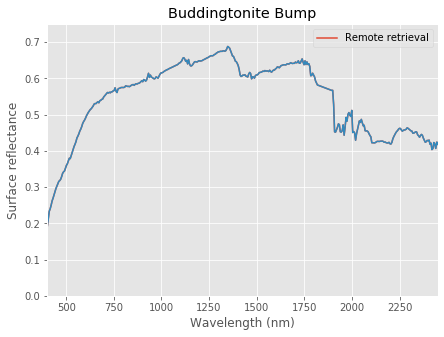

In [2]:
wavelengths, radiance = np.loadtxt('data/buddingtonite_rdn.txt').T

# Inversion
state_trajectory = iv.invert(radiance, geom)
state_est = state_trajectory[-1]

# Calculate A, G, and K matrices
rfl_est, rdn_est, path_est, S_hat, K, G = iv.forward_uncertainty(state_est, radiance, geom)
A = G @ K

# Plot the result, and compare with the in-situ measurement
figsize(7,5)
plt.plot(wavelengths, rfl_est)
plt.plot(wavelengths, rfl_est)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Surface reflectance')
plt.title('Buddingtonite Bump')
plt.legend(['Remote retrieval']);
plt.xlim([400,2450])
plt.ylim([0,0.75]);

Now we load an entire data cube of size 400 $\times$ 400 spectra.

In [3]:
filename = './data/ang20140625t192252_rdn_bip'
rows, bands, cols = 400, 425, 400
mm = np.memmap(filename, dtype=np.float32, mode='r',shape=(rows,cols,bands))

# RGB Image, with a contrast rescaling by typical radiances
rgb_indices = np.array([56,36,16])
rgb = np.asarray(mm, dtype = np.float32)[:,:,rgb_indices]
rgb = rgb / np.array([25.0, 25.0, 20.0])

Our first step is to determine a representative subset of spectra upon which to perform the full atmospheric correction.  Here we exploit "superpixel segmentation," clustering the scene into segments that are spatially contiguous and similar in radiance.  Many segmentation approaches can do this, but we favor the SLIC algorithm here (Achanta et al., 2012).  Since our standard, default implimentation assumes Euclidean distances, we do not cluster the radiances directly.  Instead, we apply SLIC in an informative orthogonal basis representation based on the top 5 principal components.

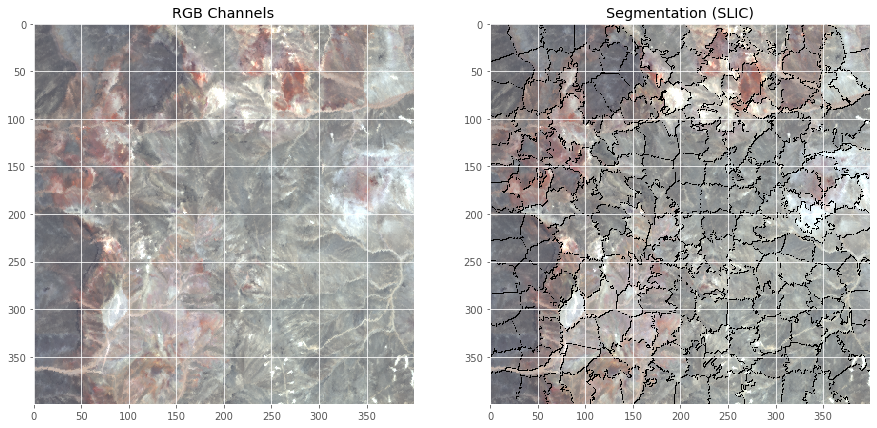

In [4]:
from skimage.segmentation import slic
from scipy.linalg import eigh, norm
from numpy.random import rand

# Change from BIP to a long list of spectra
X = np.asarray(mm, dtype = np.float32).reshape([rows*cols, bands])

# Excluding bad locations, calculate top PCA coefficients
mu = X.mean(axis=0)
C  = np.cov(X, rowvar=False)
[v,d] = eigh(C)

# Determine segmentation compactness scaling based on top 5 eigenvalues
n_pca = 5
cmpct = norm(np.sqrt(v[-n_pca:]))

# Project, redimension as an image with 5 channels, and segment
X_pca = (X-mu) @ d[:,-n_pca:]
X_pca = X_pca.reshape([rows, cols, n_pca])

segs  = 200
labels = slic(X_pca, n_segments=segs, compactness=cmpct,
              max_iter=10, sigma=0, multichannel=True,
              enforce_connectivity=True, min_size_factor=0.5,
              max_size_factor=3)
lbl = np.unique(labels)
segs = len(lbl)
color_index = lbl[np.argsort(rand(segs))]

color_labels = np.zeros((rows,cols))
for r in range(rows):
    for c in range(cols):
        color_labels[r, c] = color_index[labels[r, c]]  

borders = rgb.copy()
for r in range(1,rows):  
    for c in range(1,cols):
        if color_labels[r-1,c-1] != color_labels[r,c]:
            borders[r,c,:] = (0,0,0)

figsize(15,10)
plt.subplot(1,2,1)
plt.imshow(rgb)
plt.title('RGB Channels')
          
fig = plt.subplot(1,2,2)
plt.imshow(borders)
plt.title('Segmentation (SLIC)');

plt.savefig('segmentation.pdf');

Here is an example of the PCA projection (three of five bases illustrated using false color RGB).

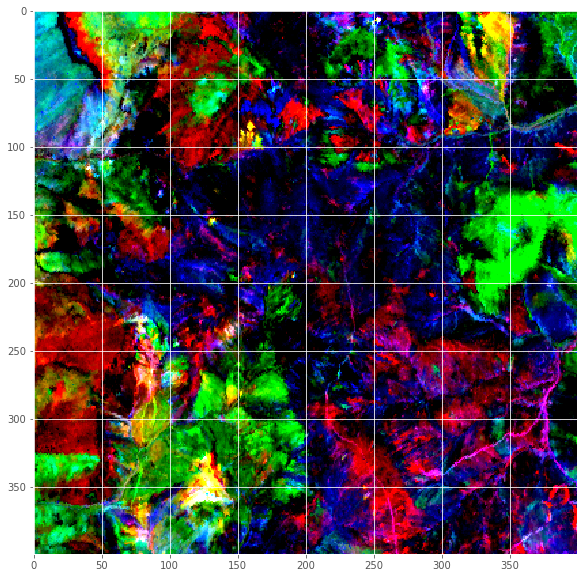

In [5]:
offset = np.array([np.mean(X_pca[:,:,i]) for i in [0,1,2]])
scaling = np.array([np.std(X_pca[:,:,i]) for i in [0,1,2]])*2.0
plt.imshow((X_pca[:,:,np.array([0,1,2])]+offset)/scaling);

Next, we perform the full inversion on this subset of representative reference spectra.

In [6]:
rdn_subset = np.zeros((segs, bands))
rfl_subset = np.zeros((segs, bands))
for i in range(segs):
    if i%5==0: 
        print('inverting %i of %i' % (i+1, segs))
    radiance = X[labels.flat == i, :].mean(axis=0)
    rdn_subset[i,:] = radiance 
    state_trajectory = iv.invert(radiance, geom)
    state_est = state_trajectory[-1]
    rfl_subset[i,:] = state_est[:len(wavelengths)];

inverting 1 of 180
inverting 6 of 180
inverting 11 of 180
inverting 16 of 180
inverting 21 of 180
inverting 26 of 180
inverting 31 of 180
inverting 36 of 180
inverting 41 of 180
inverting 46 of 180
inverting 51 of 180
inverting 56 of 180
inverting 61 of 180
inverting 66 of 180
inverting 71 of 180
inverting 76 of 180
inverting 81 of 180
inverting 86 of 180
inverting 91 of 180
inverting 96 of 180
inverting 101 of 180
inverting 106 of 180
inverting 111 of 180
inverting 116 of 180
inverting 121 of 180
inverting 126 of 180
inverting 131 of 180
inverting 136 of 180
inverting 141 of 180
inverting 146 of 180
inverting 151 of 180
inverting 156 of 180
inverting 161 of 180
inverting 166 of 180
inverting 171 of 180
inverting 176 of 180


Finally, we extrapolate the result to all spectra.  For every spectrum in the cube, we find the set of "nearest" reference spectra, and treat these radiance/reflectance pairs in an empirical line prediction.  Here we define "nearest" simply using image coordinates, but you can imagine more sophisticated geographic, environmental, or 3-D measures as well as those that look for similarity in the spectra themselves.  This is not necessary for our example.

The empirical line predicts the reflectance of a new query radiance via a least-squares linear regression that is independenet in each wavelength, based on those radiances and reflectances in the neighbor references.

In [9]:
from scipy.spatial import KDTree
from scipy.stats import linregress

# First set up a matrix of locations, one per spectrum in both
# the reference set and the image cube.  We will simply use
# row and column indices for simplicity, rather than worrying
# about geographic or 3D locations

row_grid, col_grid = np.meshgrid(np.arange(rows), np.arange(cols))
locations = np.array([col_grid.flatten(), row_grid.flatten()]).T
locations_subset = np.zeros((segs, 2))

for i in range(segs):
    locations_subset[i,:] = locations[labels.flat == i, :].mean(axis=0)
tree = KDTree(locations_subset) 

# Empirical line solution, hashing prior solutions as we go
k = 15
hash_table = {}
reflectance = np.zeros([rows*cols, bands])

for idx in range(rows * cols):  
    
    if idx%20000 == 0:
        print('extrapolating spectrum %i / %i' %(idx+1,rows*cols))
    
    # Look up the point in our KD Tree
    label_idx = labels.flat[idx]
    
    # Have we already calculated coefficients for this set of nearest-
    # neighbor spectra?
    if label_idx in hash_table:
        b = hash_table[label_idx] 
    
    # If not, treat them as a local representative set of paired 
    # radiance/reflectance spectra to enable an empirical line solution
    else:
        dists, nn  = tree.query(locations_subset[label_idx,:], k) 
        xv  = rdn_subset[nn,:]
        yv  = rfl_subset[nn,:]
        b   = np.zeros((bands,2))
        for i in np.arange(bands):
            b[i,1], b[i,0], q1, q2, q3 = linregress(xv[:,i], yv[:,i])
        hash_table[label_idx] = b
    
    # Apply the solution coefficients to spectrum "idx" in the cube
    A = np.array((np.ones(bands), X[idx,:]))
    reflectance[idx,:] = (b.T * A).sum(axis=0);


extrapolating spectrum 1 / 160000
extrapolating spectrum 20001 / 160000
extrapolating spectrum 40001 / 160000
extrapolating spectrum 60001 / 160000
extrapolating spectrum 80001 / 160000
extrapolating spectrum 100001 / 160000
extrapolating spectrum 120001 / 160000
extrapolating spectrum 140001 / 160000


As a sanity check, we plot an example regression to demonstrate that the relationship is indeed locally linear.

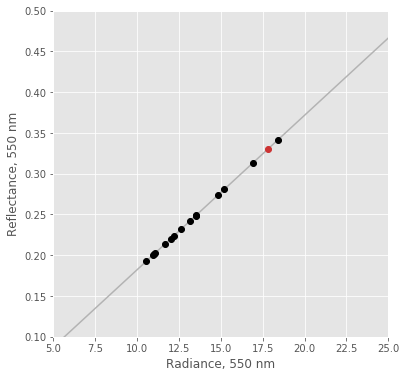

In [12]:
 # Look up the point in our KD Tree
bnd = 36
idx = 121
dists, nn  = tree.query(locations[idx,:], k)
    
xv  = rdn_subset[nn,:]
yv  = rfl_subset[nn,:]
b   = np.zeros(2)
for i in [bnd]:
   b[1], b[0], q1, q2, q3 = linregress(xv[:,i], yv[:,i])
    
figsize(6,6)
plt.plot(np.arange(30), b[0] + b[1]*np.arange(30),color=[0.7,0.7,0.7])
plt.plot(xv[:,i], yv[:,i], 'ko')
plt.plot(X[idx,i],b[0]+b[1]*X[idx,i],'o', color=[0.8,0.2,0.2])
plt.xlabel('Radiance, 550 nm')
plt.ylabel('Reflectance, 550 nm')
plt.xlim([5,25])
plt.ylim([0.1,0.5])
plt.savefig('example_empirical_line.pdf');

Now we have an entire cube of accurate reflectance data.  We show RGB channels, and save the cube to a file for easy browsing and visualization.

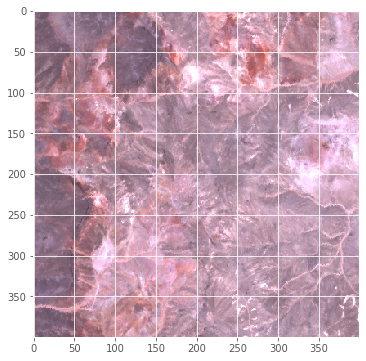

In [13]:
plt.imshow(reflectance[:,rgb_indices].reshape((rows,cols,3)) / [0.5, 0.5, 0.3])

# Save the result
filename = 'ang20140625t192252_rfl_bip'
rows, bands, cols = 400, 425, 400
mm = np.memmap(filename, dtype=np.float32, mode='w+',shape=(rows,cols,bands))
mm[:,:,:] = reflectance.reshape((rows,cols,bands))
del mm;

<b>Question:</b> Optimal estimation also provides uncertainties for the reflectance estimates in the reference set.  How can we propagate these to the empirical line result, so that every output spectrum has an associated uncertainty?

<b>Question:</b> Can you adjust the code so that the inversion respects the noise reduction achieved by averaging, using the appropriate number of spectra for each superpixel?


## References

Achanta, R., Shaji, A., Smith, K., Lucchi, A., Fua, P., & Süsstrunk, S. (2012). SLIC superpixels compared to state-of-the-art superpixel methods. IEEE transactions on pattern analysis and machine intelligence, 34(11), 2274-2282.

-------------
<b>Acknowledgements</b>: A portion of this research was performed at the Jet Propulsion Laboratory, California Institute of Technology. We acknowledge the support of a PRISM AITT grant from the National Aeronautics and Space Administration (NASA) Earth Science Technology Office. We acknowledge the support of the JPL and Caltech Presidents’ and Directors’ Fund Program. We thank other supporting sponsors including the NASA Earth Science Division for the HyspIRI preparatory campaign, the AVIRIS-NG instrument and the data analysis program “Utilization of Airborne Visible/Infrared Imaging Spectrometer Next Generation Data from an Airborne Campaign in India” NNH16ZDA001N-AVRSNG, for its support of the algorithm development; the Jet Propulsion Laboratory Research and Technology Development Program; and the NASA Center Innovation Fund managed in conjunction with the Jet Propulsion Laboratory Office of the Chief Scientist and Technologist. Copyright 2019 California Institute of Technology. US Government Support Acknowledged.